In [1]:
# 1. SETUP: installs & imports
# Run once at start

# Install packages (uncomment if needed in Colab)
!pip install --quiet gdown scikit-learn matplotlib seaborn

# Standard imports
import os
import io
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

# Make plotting look nicer
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")


In [3]:
# 2. PATHS: configure folder names (change candidate name if required)
CAND_NAME = "Sharanya_Allam"   # <-- change if needed
ROOT = f"/content/ds_{CAND_NAME}"
CSV_DIR = os.path.join(ROOT, "csv_files")
OUT_DIR = os.path.join(ROOT, "outputs")

# Create folders if they don't exist (Colab local)
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("Root folder:", ROOT)
print("CSV folder:", CSV_DIR)
print("Outputs folder:", OUT_DIR)


Root folder: /content/ds_Sharanya_Allam
CSV folder: /content/ds_Sharanya_Allam/csv_files
Outputs folder: /content/ds_Sharanya_Allam/outputs


In [4]:
# 3. DOWNLOAD datasets via gdown (uses the file IDs you supplied)
# Historical Trader Data ID and Fear & Greed Index ID
trades_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
fg_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

trades_path = os.path.join(CSV_DIR, "hyperliquid_trades.csv")
fg_path = os.path.join(CSV_DIR, "fear_greed.csv")

# download if not present
if not os.path.exists(trades_path):
    gdown.download(f"https://drive.google.com/uc?id={trades_id}", trades_path, quiet=False)
else:
    print("Found:", trades_path)

if not os.path.exists(fg_path):
    gdown.download(f"https://drive.google.com/uc?id={fg_id}", fg_path, quiet=False)
else:
    print("Found:", fg_path)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_Sharanya_Allam/csv_files/hyperliquid_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 47.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_Sharanya_Allam/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 74.8MB/s]


In [5]:
# 4. LOAD: Read CSVs and show basic info
trades = pd.read_csv(trades_path, low_memory=False)
fg = pd.read_csv(fg_path, low_memory=False)

print("Trades shape:", trades.shape)
print("FearGreed shape:", fg.shape)

display(trades.head(3))
display(fg.head(3))

# Basic column lists to verify
print("Trades columns:", list(trades.columns)[:40])
print("FearGreed columns:", list(fg.columns))


Trades shape: (211224, 16)
FearGreed shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
FearGreed columns: ['timestamp', 'value', 'classification', 'date']


In [6]:
# 5. PREPROCESS: parse datetimes and basic cleaning

# Example: standardize column names (lowercase, replace spaces)
trades.columns = [c.strip().lower().replace(" ", "_") for c in trades.columns]
fg.columns = [c.strip().lower().replace(" ", "_") for c in fg.columns]

# Parse trade time column (common names: time, timestamp). Try a few options.
time_cols = [c for c in trades.columns if 'time' in c or 'timestamp' in c]
time_cols
# pick first match
time_col = time_cols[0] if time_cols else None
print("Using time column:", time_col)

if time_col:
    trades[time_col] = pd.to_datetime(trades[time_col], errors='coerce')
else:
    print("No obvious time column — check trades.columns manually.")

# Parse date column in fear/greed file
date_candidates = [c for c in fg.columns if 'date' in c]
date_col = date_candidates[0] if date_candidates else None
print("FG date col:", date_col)
fg[date_col] = pd.to_datetime(fg[date_col], errors='coerce')

# Normalize classification column naming
if 'classification' in fg.columns:
    fg['classification'] = fg['classification'].str.strip().str.title()
else:
    print("Check fear/greed classification column name:", fg.columns)

# Quick numeric coercion for key numeric fields
for col in ['size','closedpnl','leverage','execution_price','start_position']:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')


Using time column: timestamp_ist
FG date col: date


In [11]:
# 6. FEATURES: create derived features for analysis

# Make a trade_date column (daily) from time_col
if time_col:
    trades['trade_date'] = trades[time_col].dt.tz_localize(None).dt.date
    trades['trade_date'] = pd.to_datetime(trades['trade_date'])
else:
    # fallback: if there's a date column
    if 'date' in trades.columns:
        trades['trade_date'] = pd.to_datetime(trades['date'], errors='coerce').dt.date
        trades['trade_date'] = pd.to_datetime(trades['trade_date'])

# Merge sentiment by trade_date (left join)
if 'trade_date' in trades.columns and date_col:
    fg_renamed = fg[[date_col, 'classification']].rename(columns={date_col:'date','classification':'sentiment'})
    fg_renamed['date'] = pd.to_datetime(fg_renamed['date']).dt.date
    fg_renamed['date'] = pd.to_datetime(fg_renamed['date'])
    trades = trades.merge(fg_renamed.rename(columns={'date':'trade_date'}), on='trade_date', how='left')

# Derived metrics
# is_win
if 'closed_pnl' in trades.columns:
    trades['is_win'] = (trades['closed_pnl'] > 0).astype(int)
# notional = abs(size * execution_price)
if 'size_tokens' in trades.columns and 'execution_price' in trades.columns:
    trades['notional'] = trades['size_tokens'].abs() * trades['execution_price']
# pnl per unit
trades['pnl_per_unit'] = trades['closed_pnl'] / trades['size_tokens'].abs().replace({0:np.nan})

In [12]:
# 7. SAVE cleaned CSV for submission (processed file)
processed_path = os.path.join(CSV_DIR, "hyperliquid_trades_processed.csv")
trades.to_csv(processed_path, index=False)
print("Saved processed trades to:", processed_path)


Saved processed trades to: /content/ds_Sharanya_Allam/csv_files/hyperliquid_trades_processed.csv


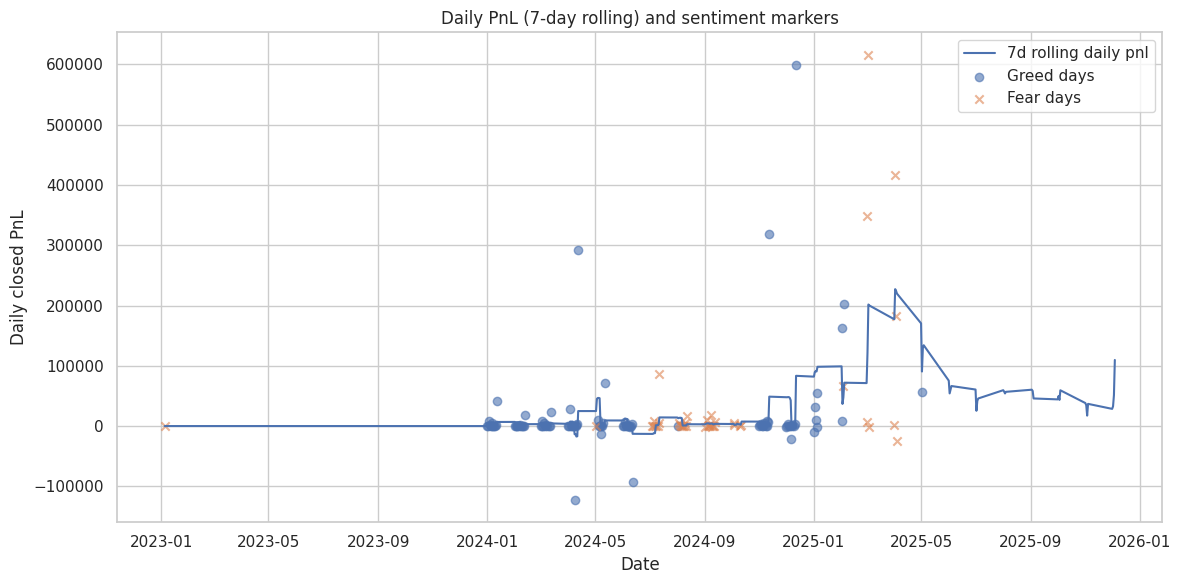

Saved: /content/ds_Sharanya_Allam/outputs/daily_pnl_vs_sentiment.png


In [14]:
# 8. EDA: aggregate daily PnL and plot sentiment vs PnL
daily = trades.groupby('trade_date').agg(
    daily_pnl = ('closed_pnl','sum'),
    daily_trades = ('closed_pnl','size'),
).reset_index()

# merge sentiment (most days may already be in trades; if not, derive from fg)
sent = fg.rename(columns={date_col:'date'}) if date_col else fg.copy()
# Use trades' sentiment if present
if 'sentiment' in trades.columns:
    daily_sent = trades.groupby('trade_date')['sentiment'].agg(lambda x: x.mode().iat[0] if len(x.dropna())>0 else np.nan).reset_index().rename(columns={'sentiment':'sentiment'})
    daily = daily.merge(daily_sent, on='trade_date', how='left')

# Plot rolling PnL and color by sentiment (points)
plt.figure(figsize=(12,6))
plt.plot(daily['trade_date'], daily['daily_pnl'].rolling(7, min_periods=1).mean(), label='7d rolling daily pnl')
# mark greed vs fear days where available
if 'sentiment' in daily.columns:
    greedy = daily[daily['sentiment'].str.contains('Greed', na=False)]
    fearful = daily[daily['sentiment'].str.contains('Fear', na=False)]
    plt.scatter(greedy['trade_date'], greedy['daily_pnl'], marker='o', label='Greed days', alpha=0.6)
    plt.scatter(fearful['trade_date'], fearful['daily_pnl'], marker='x', label='Fear days', alpha=0.6)

plt.legend()
plt.title('Daily PnL (7-day rolling) and sentiment markers')
plt.xlabel('Date')
plt.ylabel('Daily closed PnL')
plt.tight_layout()
fn = os.path.join(OUT_DIR, "daily_pnl_vs_sentiment.png")
plt.savefig(fn, bbox_inches='tight')
plt.show()
print("Saved:", fn)

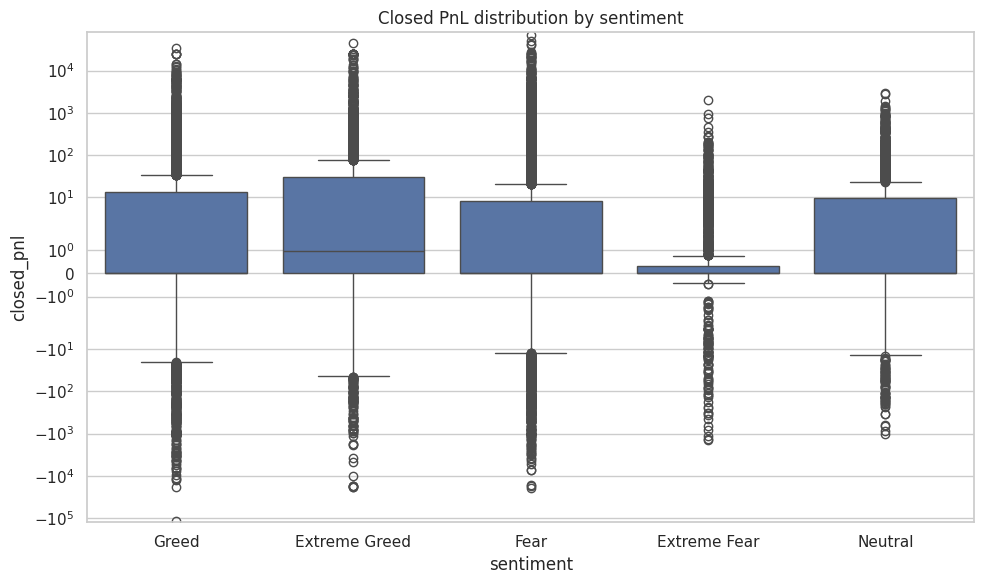

Saved: /content/ds_Sharanya_Allam/outputs/closedpnl_by_sentiment_box.png


,count,mean,median,std
sentiment,,,,
Extreme Fear,2326,1.891632,0.00000,76.727713
Extreme Greed,5621,205.816345,0.96048,1861.557119
Fear,13869,128.287950,0.00000,1342.348497
Greed,11292,53.988003,0.00000,1399.468182
Neutral,2756,27.088803,0.00000,142.945889


In [16]:
# 9. DISTRIBUTIONS: boxplots and summary stats
if 'sentiment' in trades.columns:
    subset = trades[trades['sentiment'].notnull()]
    plt.figure(figsize=(10,6))
    sns.boxplot(data=subset, x='sentiment', y='closed_pnl')
    plt.yscale('symlog')  # helpful for heavy tails
    plt.title("Closed PnL distribution by sentiment")
    plt.tight_layout()
    fn = os.path.join(OUT_DIR, "closedpnl_by_sentiment_box.png")
    plt.savefig(fn, bbox_inches='tight')
    plt.show()
    print("Saved:", fn)

    # Summary stats
    stats_by_sent = subset.groupby('sentiment')['closed_pnl'].agg(['count','mean','median','std'])
    display(stats_by_sent)

In [23]:
# 10. STAT TEST: Mann-Whitney (non-parametric) and t-test
if 'sentiment' in trades.columns:
    fear_pnl = trades.loc[trades['sentiment'].str.contains('Fear', na=False), 'closed_pnl'].dropna()
    greed_pnl = trades.loc[trades['sentiment'].str.contains('Greed', na=False), 'closed_pnl'].dropna()

    print("Fear count:", len(fear_pnl), "Greed count:", len(greed_pnl))

    # Mann-Whitney U test
    try:
        mw = stats.mannwhitneyu(greed_pnl, fear_pnl, alternative='two-sided')
        ttest = stats.ttest_ind(greed_pnl, fear_pnl, equal_var=False, nan_policy='omit')
        print("Mann-Whitney U:", mw)
        print("t-test:", ttest)
    except Exception as e:
        print("Stat test error:", e)
else:
    print("No sentiment column to compare.")

Fear count: 16195 Greed count: 16913
Mann-Whitney U: MannwhitneyuResult(statistic=np.float64(151129655.0), pvalue=np.float64(1.384301904177245e-68))
t-test: TtestResult(statistic=np.float64(-0.3661800860524017), pvalue=np.float64(0.7142331222947342), df=np.float64(31990.739074528457))


In [27]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#  Inspect data
print(trades.shape)
print(trades.columns)
trades.head()


(211224, 21)
Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'trade_date', 'is_win', 'sentiment', 'notional',
       'pnl_per_unit'],
      dtype='object')


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,trade_date,is_win,sentiment,notional,pnl_per_unit
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,0,Greed,7872.163303,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,0,Greed,127.680000,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,0,Greed,1150.630695,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,0,Greed,1142.038452,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,0,Greed,69.747462,0.0


In [28]:
# clean column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
trades.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,trade_date,is_win,sentiment,notional,pnl_per_unit
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,0,Greed,7872.163303,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,0,Greed,127.680000,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,0,Greed,1150.630695,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,0,Greed,1142.038452,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,0,Greed,69.747462,0.0


In [29]:
# Convert timestamps to datetime
trades['timestamp'] = pd.to_datetime(trades['timestamp'], errors='coerce')
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')

# Fill missing numeric values
numeric_cols = trades.select_dtypes(include=['float64', 'int64']).columns
trades[numeric_cols] = trades[numeric_cols].fillna(0)

# Drop rows with missing essential fields
trades.dropna(subset=['account', 'coin', 'side'], inplace=True)


In [30]:
# Direction indicator
trades['side'] = trades['side'].str.lower()
trades['is_long'] = np.where(trades['side'].str.contains('buy|long'), 1, 0)

# Profit ratio (PnL / Size USD)
trades['pnl_ratio'] = np.where(trades['size_usd'] != 0,
                               trades['closed_pnl'] / trades['size_usd'], 0)


In [31]:
acct_metrics = trades.groupby('account').agg(
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    pnl_std=('closed_pnl', 'std'),
    total_trades=('trade_id', 'count'),
    avg_fee=('fee', 'mean'),
    total_volume=('size_usd', 'sum'),
    long_ratio=('is_long', 'mean')
).reset_index()

acct_metrics.head()


,account,total_pnl,avg_pnl,pnl_std,total_trades,avg_fee,total_volume,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,419.127768,4692.452329,3818,1.939579,61697263.97,0.448140
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,4.788532e+04,6.577654,134.073473,7280,0.374978,12035487.66,0.419643
2,0x271b280974205ca63b716753467d5a371de622ab,-7.043619e+04,-18.492043,542.182659,3809,2.436593,33873440.42,0.411132
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1.324648e+05,9.951530,113.269353,13311,0.166657,6757022.10,0.503268
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.686580e+05,52.071011,255.829091,3239,0.959616,10166880.20,0.364001


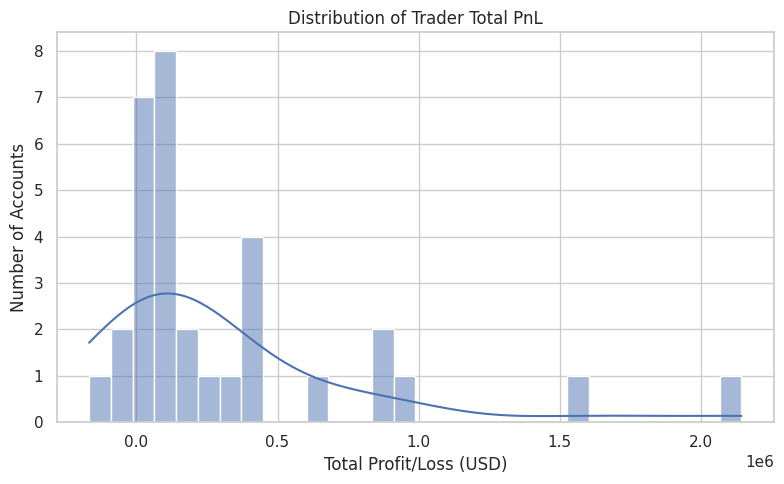

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(acct_metrics['total_pnl'], bins=30, kde=True)
plt.title('Distribution of Trader Total PnL')
plt.xlabel('Total Profit/Loss (USD)')
plt.ylabel('Number of Accounts')
plt.tight_layout()
# Correcting the save path to the local output directory
plt.savefig(os.path.join(OUT_DIR, 'pnl_distribution.png'))
plt.show()

In [35]:
# Load sentiment data
sentiment = pd.read_csv(fg_path)

# Clean & prepare
sentiment.columns = sentiment.columns.str.strip().str.lower()
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Map sentiment classification to numeric
# Checking if 'classification' column exists before mapping
if 'classification' in sentiment.columns:
    # Creating a mapping dictionary based on the observed classifications
    sentiment_mapping = {
        'Fear': 0,
        'Extreme Fear': 0,
        'Neutral': 0.5,
        'Greed': 1,
        'Extreme Greed': 1
    }
    sentiment['sentiment_score'] = sentiment['classification'].map(sentiment_mapping).fillna(0.5) # Fill any unmapped with neutral

# Merge with trades by date (assuming timestamp)
# Ensure 'trade_date' in trades is datetime and drop timezone
if 'trade_date' in trades.columns:
    trades['date'] = pd.to_datetime(trades['trade_date']).dt.date
else:
    # Fallback if trade_date doesn't exist, use timestamp_ist
    trades['date'] = pd.to_datetime(trades['timestamp_ist']).dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

merged = pd.merge(trades, sentiment, on='date', how='left')
display(merged.head())

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,sentiment,notional,pnl_per_unit,is_long,pnl_ratio,date,timestamp_y,value,classification,sentiment_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-02-12 22:50:00,0.000000,Buy,0.0,...,Greed,7872.163303,0.0,1,0.0,2024-02-12,1.707716e+09,70.0,Greed,1.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-02-12 22:50:00,986.524596,Buy,0.0,...,Greed,127.680000,0.0,1,0.0,2024-02-12,1.707716e+09,70.0,Greed,1.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,Greed,1150.630695,0.0,1,0.0,2024-02-12,1.707716e+09,70.0,Greed,1.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,Greed,1142.038452,0.0,1,0.0,2024-02-12,1.707716e+09,70.0,Greed,1.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,Greed,69.747462,0.0,1,0.0,2024-02-12,1.707716e+09,70.0,Greed,1.0


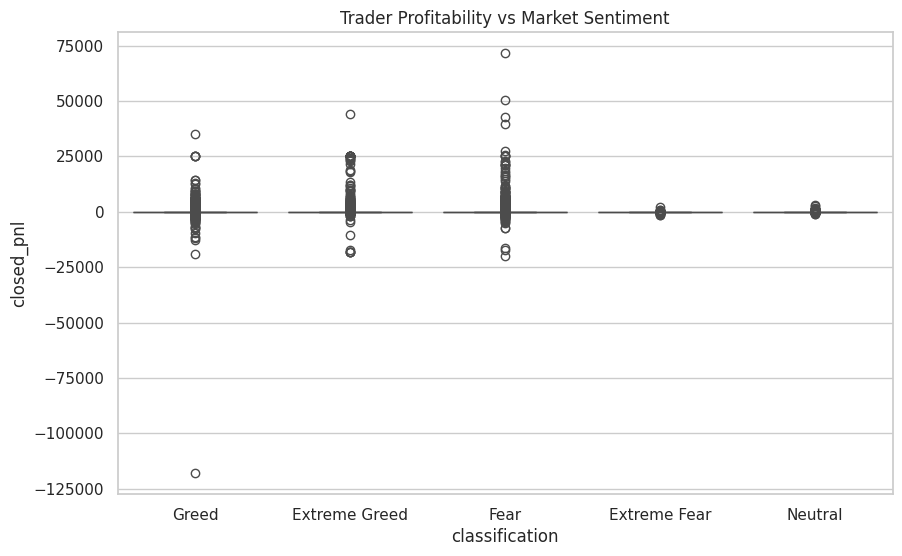

,closed_pnl
classification,
Extreme Fear,1.891632
Extreme Greed,205.816345
Fear,128.287950
Greed,53.988003
Neutral,27.088803


In [37]:
sns.boxplot(data=merged, x='classification', y='closed_pnl')
plt.title('Trader Profitability vs Market Sentiment')
plt.savefig(os.path.join(OUT_DIR, 'pnl_vs_sentiment.png'))
plt.show()

# Mean profit per sentiment type
merged.groupby('classification')['closed_pnl'].mean()

In [39]:
acct_metrics.to_csv(os.path.join(CSV_DIR, 'account_metrics.csv'), index=False)
merged.to_csv(os.path.join(CSV_DIR, 'trades_with_sentiment.csv'), index=False)

Top decile count: 4


,count,mean,std,min,25%,50%,75%,max
total_pnl,4.0,1.381050e+06,6.098769e+05,8.404226e+05,9.152285e+05,1.270197e+06,1.736018e+06,2.143383e+06
avg_pnl,4.0,1.694145e+02,1.719628e+02,4.436409e+01,6.260434e+01,1.070831e+02,2.138933e+02,4.191278e+02
pnl_std,4.0,1.818411e+03,1.950365e+03,5.677628e+02,6.214925e+02,1.006714e+03,2.203633e+03,4.692452e+03
total_trades,4.0,1.299475e+04,7.188066e+03,3.818000e+03,1.013150e+04,1.348450e+04,1.634775e+04,2.119200e+04
avg_fee,4.0,2.419200e+00,2.627177e+00,4.056581e-01,9.156743e-01,1.512629e+00,3.016155e+00,6.245885e+00
total_volume,4.0,1.517884e+08,1.794536e+08,5.654357e+07,6.040884e+07,6.486680e+07,1.562464e+08,4.208766e+08
long_ratio,4.0,4.879506e-01,4.224212e-02,4.481404e-01,4.532589e-01,4.876983e-01,5.223900e-01,5.282654e-01


/tmp/ipython-input-746490272.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=acct_metrics, x='group', y='avg_fee', palette='Set2')


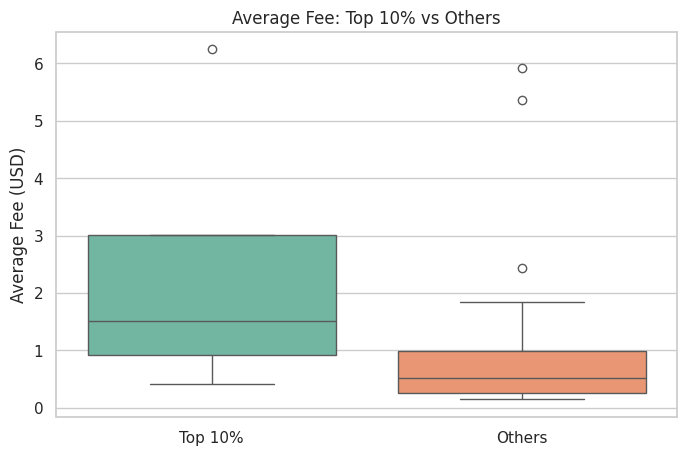

Saved: /content/drive/MyDrive/ds_Sharanya_Allam/outputs/top_vs_others_fee.png


In [44]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create output directory path
OUT_DIR = '/content/drive/MyDrive/ds_Sharanya_Allam/outputs/'
os.makedirs(OUT_DIR, exist_ok=True)   # <-- Add this line

# Identify top 10% performers by total PnL
top_decile_cut = acct_metrics['total_pnl'].quantile(0.9)
top_accounts = acct_metrics[acct_metrics['total_pnl'] >= top_decile_cut]

print("Top decile count:", top_accounts.shape[0])
display(top_accounts.describe().T)

# Create a new column to classify top vs others
acct_metrics['group'] = np.where(acct_metrics['total_pnl'] >= top_decile_cut, 'Top 10%', 'Others')

# Compare average fee of top vs others
plt.figure(figsize=(8,5))
sns.boxplot(data=acct_metrics, x='group', y='avg_fee', palette='Set2')
plt.title("Average Fee: Top 10% vs Others")
plt.xlabel("")
plt.ylabel("Average Fee (USD)")
fn = os.path.join(OUT_DIR, "top_vs_others_fee.png")
plt.savefig(fn, bbox_inches='tight')
plt.show()
print("Saved:", fn)


In [46]:
# 13. MODEL: Predict is_win using features: leverage, notional, side, sentiment
model_df = trades[['is_win','notional','side','sentiment']].copy()
model_df = model_df.dropna(subset=['is_win'])  # ensure target present

# Encode side (if needed)
model_df['side'] = model_df['side'].astype(str).str.lower()
model_df = pd.get_dummies(model_df, columns=['side','sentiment'], drop_first=True)

# Drop rows with too many NaNs
model_df = model_df.dropna()

X = model_df.drop(columns=['is_win'])
y = model_df['is_win']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scale numeric
num_cols = ['notional']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_proba = lr.predict_proba(X_test)[:,1]
auc_lr = roc_auc_score(y_test, y_pred_proba)
print("Logistic Regression AUC:", auc_lr)

# Random Forest for importance and baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("Random Forest AUC:", auc_rf)

# Feature importances
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
display(fi.head(20))

# Save feature importances
fi.to_csv(os.path.join(CSV_DIR, "feature_importances.csv"))
print("Saved feature_importances.csv")

Logistic Regression AUC: 0.6389263338090114
Random Forest AUC: 0.7034431834259947


,0
notional,0.919049
side_sell,0.075834
sentiment_Fear,0.002113
sentiment_Extreme Greed,0.001994
sentiment_Neutral,0.000566
sentiment_Greed,0.000443


Saved feature_importances.csv


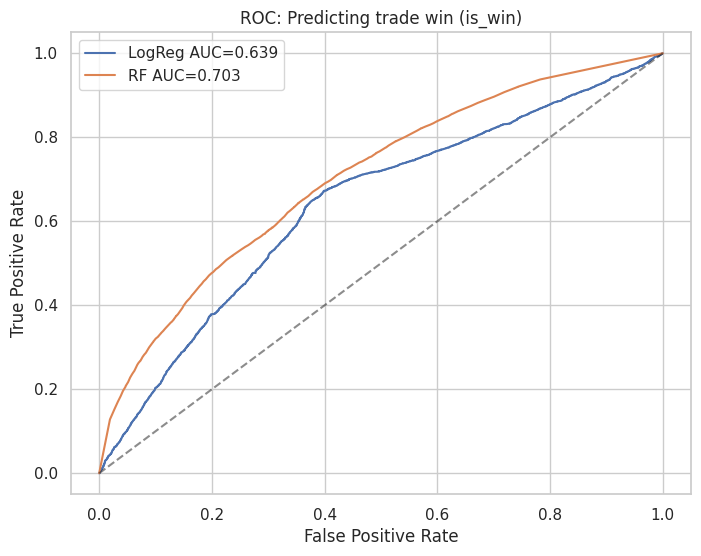

Saved: /content/drive/MyDrive/ds_Sharanya_Allam/outputs/roc_models.png


In [47]:
# 14. ROC plot (LR vs RF)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg AUC={auc_lr:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC={auc_rf:.3f}')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Predicting trade win (is_win)")
plt.legend()
fn = os.path.join(OUT_DIR, "roc_models.png")
plt.savefig(fn, bbox_inches='tight')
plt.show()
print("Saved:", fn)
